# Integer programming: the assignment problem

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from itertools import product
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

## Creating and plottlig graphs with `networkx`

Create a graph by specifying vertices and adding edges:

In [2]:
G = nx.Graph()
G.add_nodes_from(["A", "B", "C", "D", "E"])
G.add_edge("A", "B")
G.add_edge("A", "C")
G.add_edge("B", "C")
G.add_edge("C", "D")
G.add_edge("C", "E")

Check vertices and edges: 

In [3]:
G.nodes

NodeView(('A', 'B', 'C', 'D', 'E'))

In [4]:
G.edges

EdgeView([('A', 'B'), ('A', 'C'), ('B', 'C'), ('C', 'D'), ('C', 'E')])

Plot the graph:

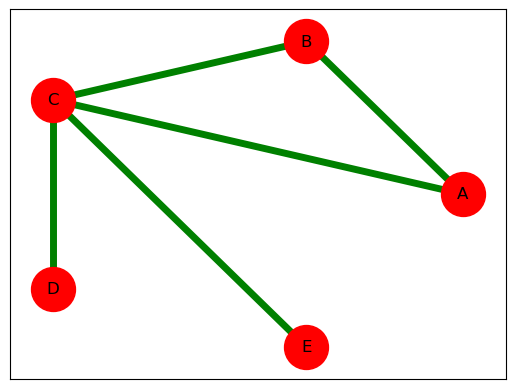

In [5]:
#plt.figure(figsize=(6,6))
#ax = plt.gca()
#ax.set_aspect("equal")

nx.draw_networkx(G, 
                 pos=nx.circular_layout(G),
                 node_size=1000,         
                 node_color='red',
                 edge_color='green',
                 width=5,
                 )
plt.show()


Generate the incidence matrix of the graph:

In [6]:
nx.incidence_matrix(G).todense()

array([[1., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0.],
       [0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

## The assignment problem

The functions below create a networkx graph from an matrix with an assignment problem data 
and plot the graph. 

In [7]:
def graph_from_scores(scores):
    """
    Given an array with scores of the assignment problem 
    returns the corresponding weighted networkx graph. 
    Column nodes are labeled C1, C2, etc., row nodes P1, P2, etc.   

    scores:
        A 2-dimensional array with the assignment problem data.

    Returns: 
        A networkx weighted graph object.
    """

    scores = np.array(scores)
    df = pd.DataFrame(scores,
                      index=[f"P{i}" for i in range(1, scores.shape[0] + 1)],
                      columns=[f"C{i}" for i in range(1, scores.shape[1] + 1)])
    B = nx.Graph()  
    B.add_nodes_from([f"C{i}" for i in range(1, scores.shape[1] + 1)])
    B.add_nodes_from([f"P{i}" for i in range(1, scores.shape[0] + 1)])
    for p, c in product(df.index, df.columns):
        if (w := df.at[p, c]) > 0:
            B.add_edge(p, c, weight=w)
    return B, df


def plot_assignment_graph(B, edge_color='k'):
    """
    Plot the graph for an assignment problem. 

    B:
        A networkx object representing a weighted bipartite graph.
    
    Returns: 
        None. 
    """

    plt.figure(figsize=(8, 5))
    node_color = ['lightcoral' if n.startswith("C") else 'lightsteelblue' for n in B.nodes]
    nx.draw_networkx(
        B,
        pos = nx.drawing.layout.bipartite_layout(B, nodes = [n for n in B.nodes if n.startswith("C")]), 
        width = 3,
        node_color=node_color,
        edge_color=edge_color,
        node_size=1000
    )
    plt.show()


Create and plot the bipartite graph:

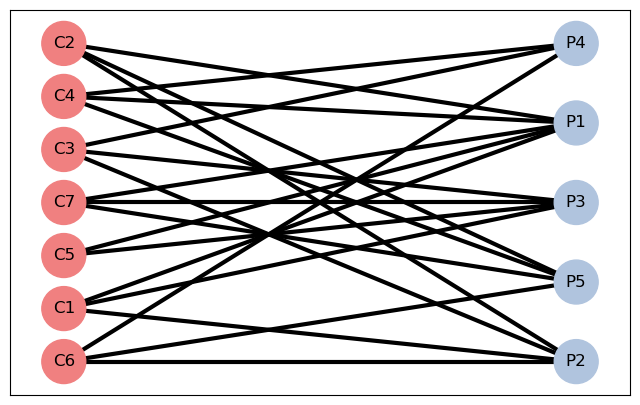

In [8]:
scores = np.array([[70, 90,  0, 75, 55,  0, 60],
                   [40, 95, 85,  0,  0, 80,  0],
                   [50,  0, 75,  0, 70,  0, 65],
                   [ 0,  0, 60, 80,  0, 35,  0],
                   [0,  75,  0, 70,  0, 35, 20]])

B, _ = graph_from_scores(scores)
plot_assignment_graph(B)


The code below uses the graph `B` produced above to print 
the incidence matrix of the graph:

In [9]:
with np.printoptions(linewidth=100):
    print(nx.incidence_matrix(B).todense())

[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.]]


The next function solves an assignment problem, taking as its input the graph `B` produced above.

In [10]:
def lp_assignment(B):
    """
    Sets up and solves the assignment problem for
    a given weighted bipartite graph.
    
    B:
        A networkx object representing a weighted bipartite graph.
    
    Returns: 
       The data with the linear program solution returned by 
       scipy.optimize.linprog. 
    
    """
    weighted_incidence = nx.incidence_matrix(B, weight="weight").todense()
    edge_weights = weighted_incidence.max(axis=0)
    incidence =  nx.incidence_matrix(B)
    num_slacks = len([n for n in B.nodes if n.startswith("C")])

    c = -edge_weights

    A_ub = incidence[:num_slacks]
    b_ub = np.ones(num_slacks)
    A_eq = incidence[num_slacks:]
    b_eq = np.ones(len(B.nodes) - num_slacks)

    sp = scipy.optimize.linprog(c=c,
                                A_ub=A_ub,
                                b_ub=b_ub,
                                A_eq=A_eq,
                                b_eq=b_eq)
    return sp

In [11]:
sol = lp_assignment(B)
sol

           con: array([0., 0., 0., 0., 0.])
 crossover_nit: 0
         eqlin:  marginals: array([-70., -80., -70., -65., -55.])
  residual: array([0., 0., 0., 0., 0.])
           fun: -380.0
       ineqlin:  marginals: array([ -0., -20.,  -5., -15.,  -0.,  -0.,  -0.])
  residual: array([0., 0., 0., 0., 1., 0., 1.])
         lower:  marginals: array([ 0., 40., 20.,  0.,  5.,  0.,  0.,  0., 10., 10.,  0.,  0., 15.,
        0.,  0., 30., 20., 10.,  5., 35.])
  residual: array([ 1.,  0.,  0., -0.,  0.,  1., -0.,  1.,  0.,  0.,  1., -0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.])
       message: 'Optimization terminated successfully. (HiGHS Status 7: Optimal)'
           nit: 9
         slack: array([0., 0., 0., 0., 1., 0., 1.])
        status: 0
       success: True
         upper:  marginals: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])
  residual: array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf

In [12]:
sol.x

array([ 1.,  0.,  0., -0.,  0.,  1., -0.,  1.,  0.,  0.,  1., -0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.])

To get a readable solution of the assignment problem, it is now enough to print information about the edges of the graph for which the linear program solution is equal to 1:

In [13]:
edges = np.array([*B.edges(data=True)])
assignment = edges[sol.x == 1]
print(assignment)

[['C1' 'P1' {'weight': 70}]
 ['C2' 'P5' {'weight': 75}]
 ['C3' 'P3' {'weight': 75}]
 ['C4' 'P4' {'weight': 80}]
 ['C6' 'P2' {'weight': 80}]]


The sum of weights of the optimal assignment:

In [14]:
sum([w["weight"] for c, p, w in assignment])

380

Putting it all together:

In [15]:
def solve_assignment(scores):
    """
    Given an array with scores of the assignment problem, 
    computes the solution of the problem, prints it and
    plots the graph highlighting edges that give the solution.  
    
    Column nodes are labeled C1, C2, etc., row nodes P1, P2, etc.   

    scores:
        A 2-dimensional array with the assignment problem data.

    Returns: 
        None.
    """

    B, scores_df = graph_from_scores(scores)
    print("Scores:")
    display(scores_df)
    sol = lp_assignment(B)
    print("\nLinear program solution:")
    if sol.x is None: 
        print("no solution")
        return None
    print(sol.x)
    edges = np.array([*B.edges(data=True)])
    assignment = edges[sol.x > 0]
    max_score = sum([w["weight"] for c, p, w in assignment])

    print("\nOptimal assignment:")
    for e in assignment: 
        print(e)
    print(f"\nMaximal score: {max_score}")
    edge_color = ['r' if i else 'lightgray' for i in sol.x]
    plot_assignment_graph(B, edge_color=edge_color)

Scores:


,C1,C2,C3,C4,C5,C6,C7
P1,70,90,0,75,55,0,60
P2,40,95,85,0,0,80,0
P3,50,0,75,0,70,0,65
P4,0,0,60,80,0,35,0
P5,0,75,0,70,0,35,20



Linear program solution:
[ 1.  0.  0. -0.  0.  1. -0.  1.  0.  0.  1. -0.  0.  0.  1.  0.  0.  0.
  0.  0.]

Optimal assignment:
['C1' 'P1' {'weight': 70}]
['C2' 'P5' {'weight': 75}]
['C3' 'P3' {'weight': 75}]
['C4' 'P4' {'weight': 80}]
['C6' 'P2' {'weight': 80}]

Maximal score: 380


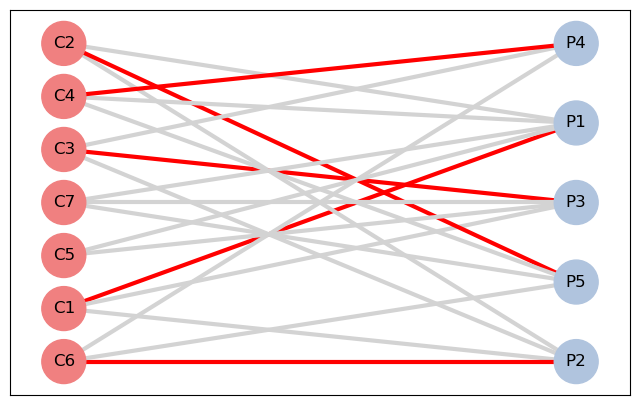

In [16]:
scores = [[70, 90,  0, 75, 55,  0, 60],
          [40, 95, 85,  0,  0, 80,  0],
          [50,  0, 75,  0, 70,  0, 65],
          [ 0,  0, 60, 80,  0, 35,  0],
          [0,  75,  0, 70,  0, 35, 20]]


solve_assignment(scores)

The assignment problem with a randomly generated scores matrix:

Scores:


,C1,C2,C3,C4,C5,C6,C7,C8
P1,0,54,0,0,0,0,0,39
P2,0,1,0,0,12,93,67,0
P3,0,0,0,89,0,54,0,79
P4,0,0,10,95,0,57,35,56
P5,0,85,44,0,2,0,30,0
P6,0,0,0,23,80,89,73,0



Linear program solution:
[ 1.  0. -0.  0.  1. -0.  1.  0.  0.  0.  1.  1.  0.  0. -0.  0.  0.  0.
  0. -0.  1.  0.]

Optimal assignment:
['C2' 'P1' {'weight': 54}]
['C3' 'P5' {'weight': 44}]
['C4' 'P4' {'weight': 95}]
['C5' 'P6' {'weight': 80}]
['C6' 'P2' {'weight': 93}]
['C8' 'P3' {'weight': 79}]

Maximal score: 445


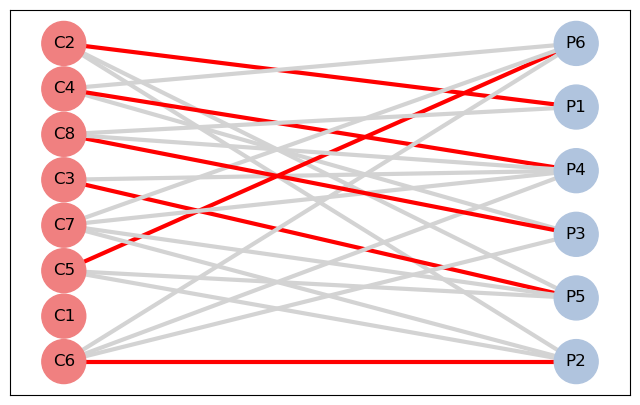

In [17]:
rng = np.random.default_rng()
# random matrix with scores
A = rng.integers(0, 100, (6, 8))
# add some zeros to the scores
p = 0.5
Z = (rng.random(A.shape) > p).astype(int)
A = A * Z
# compute the optimal assignment 
solve_assignment(A)
